In [57]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1524)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print("dasdasdsa",e)

import numpy as np
from scipy.io import arff
import pandas as pd
import matplotlib.pyplot as plt

#sklearn
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.svm import NuSVR
#Keras imports
from keras import backend as K

from keras.layers import Input, Dense
from keras.optimizers import RMSprop, SGD, Adagrad,Adam,Adadelta,Adamax,Nadam
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Lambda, BatchNormalization
from keras.optimizers import SGD, Adagrad, Adam

from time import time
import math

1 Physical GPUs, 1 Logical GPUs


In [58]:
# !pip install pandas scikit-learn numpy keras

### 

In [59]:
#Data from files
# 'graph', 'extend', 'minus', 'order', 'reduced', 'group', 'slice'
data_algebra = load_csv_data("./dataclei/algebra_features.txt",drop_columns=[])
data_medoids = load_csv_data("./dataclei/vectors_medoids.csv",drop_columns=[])
print(data_algebra.shape,data_medoids.shape)

gpf_algebra = data_algebra.merge(data_medoids, left_on='query_id', right_on='id')
gpf_algebra.head()
gpf_algebra = gpf_algebra.drop(columns=["query_id","Unnamed: 27_x","Unnamed: 27_y"])

nunique = gpf_algebra.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
print("Remove columns with same values: {}".format(cols_to_drop))
gpf_algebra = gpf_algebra.drop(cols_to_drop, axis=1)
#/////
new_cols = list(gpf_algebra.columns[:-25]) + ['pcs'+str(i) for i in list(range(0,25))]
gpf_algebra.columns = new_cols
#/////
gpf_algebra = gpf_algebra[gpf_algebra['time'] < 15000]
X_temp, X_test = train_test_split(gpf_algebra, test_size=0.25, random_state=42, shuffle=True)
#/////
X_train, X_val = train_test_split(
    X_temp, test_size=0.30, random_state=42,shuffle=True)
print("Shapes : Train: {} Val: {}, Test: {}".format(X_train.shape, X_val.shape, X_test.shape))

Loading data
Removing columns []
Loading data
Removing columns []
(19171, 28) (19113, 28)
Remove columns with same values: Index(['path*', 'pathN*', 'path+', 'pathN+', 'notoneof', 'tolist', 'multi',
       'top', 'assign', 'sequence'],
      dtype='object')
Shapes : Train: (9947, 43) Val: (4264, 43), Test: (4737, 43)


In [60]:
#Load data joins predicates and filters on tpf
data_tpf = pd.read_csv("data_neo/datasetlsq_output_rlearningtfeat.csv", delimiter="ᶶ")
data_tpf = data_tpf.drop(columns=["Unnamed: 4",'execTime'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  


In [61]:
from keras.utils import to_categorical

def filter_only_string_non_empty(x):
    if(type(x) == float):
        return False
    return x.replace("EMPTY_VALUE","")

def uri_2_index_seq(x,uri2Index):
    """transform uris to sequences"""
    lista  = [uri2Index[a] for a in x]
#     print(lista)
    return lista
def get_joins(x):
    if type(x) != str:
        return []
    lista = [a for a in x.split("ᶷ") if a != ""]
    if len(lista) == 1:
        return []
    valsjoins = []
    for i in range(len(lista))[::2]:
        valsjoins.append([lista[i],lista[i+1]])
    return valsjoins

In [62]:
def convert_string2dict(x):
    """Convertir string en un dict donde las keys son los pareces y los valores los impares, ignora llaves sin valores y llaves empty"""
    if type(x) is float and math.isnan(x):
        return {}
    if x is None:
        return {}
    values = x.split("ᶷ")
    rango = range(len(values))
    resp = {}
    for i in rango:
        if(i%2 == 0 and values[i] != ""):
            try:
                resp[values[i]] = values[i+1]
            except:
                print("error con ", values[i], x)
    return resp

def get_sum_values(x):
    total = 0
    for val in list(x.values()):
        total += float(val)
    return total

def selectivity(val,low, high, distinct, operator):
    """
    Calculate Select Estimation  sel_A<=c """
    if(operator == "<="):
        select = (val-low)/(high - low)
    elif(operator == ">="):
        select = 1- ((val-low)/(high - low))
    elif(operator == "="):
        select = (1/distinct)
    else:
        select = (distinct-1)/(distinct)
    return 1
def get_hist_value(predicate, operator, on, value):
    """
    predicate: predicado uri para extraer la información del histograma.
    operator:
    value: valor para filtrar, si es
    return el valor.
    """
    if(value == "ALL"):
        #Si es ALL la selectividad es 1
        return 1
    
    data = data_tpf_histdata[data_tpf_histdata['predicate'] == predicate]
    data = data[data['on'] == on]
    if data.shape[0] > 0:
        hist_data = data['hist_array'].values[0]
        distinct = len(hist_data)
        if distinct == 0:
            # Todo, revisar que pasa en caso de que distinct es cero
            return 0
        type_row = data['type'].values[0]
        if type_row == "uri":
            #Todo ver que se hace con la selectividad, aqui, si es el total de duplicados sobre el total de elementos o total 
            if value in hist_data:
                #return float(hist_data[value])/distinct
                return float(1)/distinct
            else:
                # Suponemos que el valor es 1 si no se muestreo en el hist.                 
                return float(1)/distinct
        elif type_row == "numeric":
            min_v = float(hist_data['min'])
            max_v = float(hist_data['max'])
            distinct_v = float(hist_data['distinct'])
            print(hist_data)
            try:
                value = float(value) 
            except ValueError:
                print("[{}] input is not a number. It's a string".format(value))
                #Todo verificar que hacer cuando el supuesto número es un str no numerico, de momento devolvemos  1/distinct
                return float(1)/distinct_v
            return selectivity(value, min_v, max_v, distinct_v, operator)
#      If not return max selectivity
    return 1
def get_pred_list(data):
    pass
def pred_2_hist(x):
    resp = {'uri':0,'num':0,'literal':0}
    if(type(x) != str):
        return resp
    data = [el for el in x.split("ᶷ") if el != ""]
#     print(data)
#     get_hist_value(predicate, operator, value)
    for i in range(len(data)):
        if i%4 == 0:
            uri = data[i]
            operator = data[i+1]
            on = data[i+2]
            val = data[i+3]
#             select = get_hist_value(uri, operator, on, val)
            if(val.startswith("http")):
                resp['uri'] += 1
            elif(val.isnumeric()):
                resp['num'] += 1
            elif(val != "ALL"):
                resp['literal'] += 1
    return resp

def get_filter_by_type(x, typeOf):
    try:
        return x[typeOf]
    except: print(x)

In [63]:
data_tpf['predicates'] = data_tpf['predicates'].apply(lambda x: filter_only_string_non_empty(x))
data_tpf['joinsv1'] =  data_tpf['joins'].apply(lambda x: get_joins(x))
data_tpf['joins_count'] = data_tpf['joinsv1'].apply(lambda x: len(x))
data_tpf['predicates_select'] = data_tpf['predicates'].apply(lambda x: pred_2_hist(x))

In [64]:
data_tpf['filter_uri'] = data_tpf['predicates_select'].apply(lambda x: get_filter_by_type(x, 'uri'))
data_tpf['filter_num'] = data_tpf['predicates_select'].apply(lambda x: get_filter_by_type(x, 'num'))
data_tpf['filter_literal'] = data_tpf['predicates_select'].apply(lambda x: get_filter_by_type(x, 'literal'))

In [65]:
 data_tpf_clean = data_tpf[['id','joins_count','filter_uri','filter_num','filter_literal']]

In [66]:
data_tpf_clean

,id,joins_count,filter_uri,filter_num,filter_literal
0,http://lsq.aksw.org/res/DBpedia-q113812,2,0,0,1
1,http://lsq.aksw.org/res/DBpedia-q113813,0,1,0,0
2,http://lsq.aksw.org/res/DBpedia-q113814,0,1,0,0
3,http://lsq.aksw.org/res/DBpedia-q113815,0,3,0,0
4,http://lsq.aksw.org/res/DBpedia-q113817,0,1,0,0
...,...,...,...,...,...
19149,http://lsq.aksw.org/res/LGD-q285726,22,3,0,0
19150,http://lsq.aksw.org/res/LGD-q214586,6,3,0,0
19151,http://lsq.aksw.org/res/LGD-q279150,6,3,0,0
19152,http://lsq.aksw.org/res/LGD-q279542,22,5,0,0


In [67]:
X_train_extended = X_train.merge(data_tpf_clean, left_on='id', right_on='id')
X_val_extended = X_val.merge(data_tpf_clean, left_on='id', right_on='id')
X_test_extended = X_test.merge(data_tpf_clean, left_on='id', right_on='id')

In [68]:
X_train_extended = X_train_extended.set_index('id')
X_val_extended = X_val_extended.set_index('id')
X_test_extended = X_test_extended.set_index('id')
### 
X_train_extended = X_train_extended.drop(columns=['join'])
X_val_extended = X_val_extended.drop(columns=['join'])
X_test_extended = X_test_extended.drop(columns=['join'])

In [69]:
X_train_extended.columns,X_val_extended.columns

(Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
        'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
        'treesize', 'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
        'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
        'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
        'pcs22', 'pcs23', 'pcs24', 'joins_count', 'filter_uri', 'filter_num',
        'filter_literal'],
       dtype='object'),
 Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
        'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
        'treesize', 'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
        'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
        'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
        'pcs22', 'pcs23', 'pcs24', 'joins_count', 'filter_uri', 'filter_num',
        'filter_literal

In [70]:
#Standarizar
def normalizaAlgebra(X_train_extended, X_val_extended, X_test_extended):
    x_columns_to_norm = ['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
        'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
        'treesize','joins_count', 'filter_uri', 'filter_num', 'filter_literal']
    scalerx = StandardScaler()
    x_train_scaled = scalerx.fit_transform(X_train_extended[x_columns_to_norm]);
    x_val_scaled = scalerx.transform(X_val_extended[x_columns_to_norm]);
    x_test_scaled = scalerx.fit_transform(X_test_extended[x_columns_to_norm]);

    scaled_df_train = pd.DataFrame(x_train_scaled, index=X_train_extended.index, columns=x_columns_to_norm)
    scaled_df_val = pd.DataFrame(x_val_scaled, index=X_val_extended.index, columns=x_columns_to_norm)
    scaled_df_test = pd.DataFrame(x_test_scaled, index=X_test_extended.index, columns=x_columns_to_norm)
    return scaled_df_train, scaled_df_val, scaled_df_test

def joinAlgebraGPM(Train_alg, Val_alg, Test_alg, Train_gpm, Val_gpm, Test_gpm):
    mergedTrain = Train_alg.merge(Train_gpm, left_index=True, right_index=True)
    mergedVal   = Val_alg.merge(  Val_gpm,   left_index=True, right_index=True)
    mergedTest  = Test_alg.merge( Test_gpm,  left_index=True, right_index=True)
    return mergedTrain, mergedVal, mergedTest

In [71]:
scaled_df_train, scaled_df_val, scaled_df_test = normalizaAlgebra(X_train_extended, X_val_extended, X_test_extended)

In [72]:
col_gpm = [
    'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5', 'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 
    'pcs13', 'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21', 'pcs22', 'pcs23', 'pcs24'
]
x_train, x_val, x_test = joinAlgebraGPM(scaled_df_train, scaled_df_val, scaled_df_test, X_train_extended[col_gpm], X_val_extended[col_gpm], X_test_extended[col_gpm])

In [74]:
def baseline_svr(C, nu, Xdata, Ydata):
    
    sv = NuSVR(C=C, nu=nu)

    t0=time()
    print("before train: Init time: {}".format(round(t0,3)))

    sv.fit(Xdata, Ydata)
    t1=time()
    
    print("after train, finish time: {}".format(round(t1,3)))
    print("training time {}",format(round(t1-t0,3)))
    return [sv, round(t1-t0, 3)]

def get_metrics_svr_model(sv, scalery, x_train, y_train, y_log_std):
    
    y_train_hat_svr = scalery.inverse_transform(sv.predict(x_train).reshape(-1, 1))

    #MSE for valid
    mse_svr_curr      = np.sqrt(mean_squared_error(y_train, y_train_hat_svr))

    scores_train_curr = sv.score(x_train, y_log_std)
    
    return mse_svr_curr, scores_train_curr
#     print("MSE val: {}, MSE train {}, R2 val:{}, R2 train:{}".format(mse_svr_val_curr, mse_svr_curr, scores_val_curr, scores_train_curr))
#     print("MSE test: {}, R2 test:{}".format(mse_svr_test_curr, scores_test_curr))
#     dftable = dftable.append(pd.Series([
#                                 C, nu, mse_svr_curr, mse_svr_val_curr, mse_svr_test_curr,
#                                 scores_train_curr, scores_val_curr, scores_test_curr,
#                                 training_time]), ignore_index=True
#                             )
#     return dftable

In [75]:
def search_hiperparameter_svr(df_train, data_val, data_test):
    import random
    result_baseline_model = []
    dftable = pd.DataFrame(columns=[])
    x_train, x_val, x_test , y_train, y_val, y_test, y_train_log, y_val_log, y_test_log = scale_log_data_targets(df_train, data_val, data_test)
    print("Shape datasets x: {}".format(x_train.shape))
    print("Shape datasets xval: {}".format(x_val.shape))
    print("Shape datasets xtest: {}".format(x_test.shape))
    print("Columns datasets after normalize.", x_train.columns)
    # scale target using StandarSacaler
    scalery, y_train_log_std, y_val_log_std, y_test_log_std = normalize_target(y_train_log, y_val_log, y_test_log)

    for i in range(1, 10):
        C = random.randrange(100, 350, 20)
        nu = random.randrange(10, 50, 5)/100
        result_baseline_model
        #Train model
        sv, training_time = baseline_svr(C, nu, x_train.values, y_train_log_std)

        rmse_train, r2_train = get_metrics_svr_model(sv, scalery, x_train.values, y_train, y_train_log_std)
        rmse_val, r2_val = get_metrics_svr_model(sv, scalery, x_val.values, y_val, y_val_log_std)
    #     rmse_test, r2_test = get_metrics_svr_model(sv, scalery, x_test, y_test, y_test_hat_svr)

        print("MSE train: {}, R2 train {}".format(rmse_train, r2_train))
        print("MSE val: {}, R2 val {}".format(rmse_val, r2_val))
    #     print("MSE test: {}, R2 test:{}".format(mse_svr_test_curr, scores_test_curr))
        dftable = dftable.append(pd.Series([
                                    C, nu, rmse_train, rmse_val, 0,
                                    r2_train, r2_val, 0,
                                    training_time]), ignore_index=True
                                )
        result_baseline_model.append(sv)
    return dftable, result_baseline_model

In [76]:
search_hiperparameter_svr(x_train, x_val, x_test)

targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 44)
Shape datasets xval: (4264, 44)
Shape datasets xtest: (4735, 44)
Columns datasets after normalize. Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5', 'pcs6', 'pcs7', 'pcs8',
       'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13', 'pcs14', 'pcs15', 'pcs16',
       'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21', 'pcs22', 'pcs23', 'pcs24'],
      dtype='object')
before train: Init time: 1590441605.858


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1590441832.029
training time {} 226.17
MSE train: 1074.2803351981609, R2 train 0.846598093866788
MSE val: 1003.9710001958751, R2 val 0.8232385703729649
before train: Init time: 1590441839.564


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1590442303.626
training time {} 464.061
MSE train: 1074.2860635793518, R2 train 0.8392917204165781
MSE val: 1003.9862681958933, R2 val 0.8144218177452784
before train: Init time: 1590442315.962


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1590442590.319
training time {} 274.357
MSE train: 1074.2986744337709, R2 train 0.8367258986270356
MSE val: 1003.9882618895024, R2 val 0.8175430744911409
before train: Init time: 1590442602.475


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1590442687.52
training time {} 85.044
MSE train: 1074.270493098645, R2 train 0.8430058389540742
MSE val: 1003.9625403807535, R2 val 0.8254387400055652
before train: Init time: 1590442693.366


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1590443029.736
training time {} 336.37
MSE train: 1074.2945167250004, R2 train 0.8417863294180039
MSE val: 1003.9921375599096, R2 val 0.8185877062480004
before train: Init time: 1590443040.43


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1590443239.139
training time {} 198.709
MSE train: 1074.3076453340698, R2 train 0.8297028841041927
MSE val: 1003.9855485532279, R2 val 0.8141732272885831
before train: Init time: 1590443251.334


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1590443312.023
training time {} 60.689
MSE train: 1074.4647509548788, R2 train 0.7897887717621875
MSE val: 1004.1622969189823, R2 val 0.7722808227395953
before train: Init time: 1590443316.098


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1590444118.039
training time {} 801.941
MSE train: 1074.2869538065218, R2 train 0.8378168821350933
MSE val: 1003.9873183574275, R2 val 0.8135538959232003
before train: Init time: 1590444131.564


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1590445133.171
training time {} 1001.607
MSE train: 1074.2804719432434, R2 train 0.8389999551639122
MSE val: 1003.981281967964, R2 val 0.8122663000412961


(       0     1            2            3    4         5         6    7  \
 0  340.0  0.20  1074.280335  1003.971000  0.0  0.846598  0.823239  0.0   
 1  260.0  0.35  1074.286064  1003.986268  0.0  0.839292  0.814422  0.0   
 2  160.0  0.35  1074.298674  1003.988262  0.0  0.836726  0.817543  0.0   
 3  180.0  0.15  1074.270493  1003.962540  0.0  0.843006  0.825439  0.0   
 4  240.0  0.30  1074.294517  1003.992138  0.0  0.841786  0.818588  0.0   
 5  100.0  0.35  1074.307645  1003.985549  0.0  0.829703  0.814173  0.0   
 6  340.0  0.10  1074.464751  1004.162297  0.0  0.789789  0.772281  0.0   
 7  240.0  0.40  1074.286954  1003.987318  0.0  0.837817  0.813554  0.0   
 8  320.0  0.40  1074.280472  1003.981282  0.0  0.839000  0.812266  0.0   
 
           8  
 0   226.170  
 1   464.061  
 2   274.357  
 3    85.044  
 4   336.370  
 5   198.709  
 6    60.689  
 7   801.941  
 8  1001.607  ,
 [NuSVR(C=340, cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
        max_iter

In [77]:
def train_bestmodel_svr(C, nu, df_train, data_val, data_test):
    import random
    result_baseline_model = []
    dftable = pd.DataFrame(columns=[])
    x_train, x_val, x_test , y_train, y_val, y_test, y_train_log, y_val_log, y_test_log = scale_log_data_targets(df_train, data_val, data_test)
    print("Shape datasets x: {}".format(x_train.shape))
    print("Shape datasets xval: {}".format(x_val.shape))
    print("Shape datasets xtest: {}".format(x_test.shape))
    print("Columns datasets after normalize.", x_train.columns)
    # scale target using StandarSacaler
    scalery, y_train_log_std, y_val_log_std, y_test_log_std = normalize_target(y_train_log, y_val_log, y_test_log)

    for i in range(1, 10):

        result_baseline_model
        #Train model
        sv, training_time = baseline_svr(C,nu, x_train.values, y_train_log_std)

        rmse_train, r2_train = get_metrics_svr_model(sv, scalery, x_train.values, y_train, y_train_log_std)
        rmse_val, r2_val = get_metrics_svr_model(sv, scalery, x_val.values, y_val, y_val_log_std)
        rmse_test, r2_test = get_metrics_svr_model(sv, scalery, x_test.values, y_test, y_test_log_std)

        print("MSE train: {}, R2 train {}".format(rmse_train, r2_train))
        print("MSE val: {}, R2 val {}".format(rmse_val, r2_val))
        print("MSE test: {}, R2 test:{}".format(rmse_test, r2_test))
        dftable = dftable.append(pd.Series([
                                    C, nu, 
                                    rmse_train, rmse_val, rmse_test,
                                    r2_train, r2_val, r2_test,
                                    training_time]), ignore_index=True
                                )
        result_baseline_model.append(sv)
    return dftable, result_baseline_model

### Best SVR results 10 runs.

In [93]:
dftable, result_baseline_model = train_bestmodel_svr(220.0, 0.45, x_train, x_val, x_test)

targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 44)
Shape datasets xval: (4264, 44)
Shape datasets xtest: (4735, 44)
Columns datasets after normalize. Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5', 'pcs6', 'pcs7', 'pcs8',
       'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13', 'pcs14', 'pcs15', 'pcs16',
       'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21', 'pcs22', 'pcs23', 'pcs24'],
      dtype='object')
before train: Init time: 1590498783.195


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1590499612.584
training time {} 829.388
MSE train: 1074.2840409771836, R2 train 0.8376398123865204
MSE val: 1003.983914313892, R2 val 0.8141377285833609
MSE test: 946.3536678589339, R2 test:0.835016441045255
before train: Init time: 1590499634.174


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1590500464.573
training time {} 830.399
MSE train: 1074.2840409771836, R2 train 0.8376398123865204
MSE val: 1003.983914313892, R2 val 0.8141377285833609
MSE test: 946.3536678589339, R2 test:0.835016441045255
before train: Init time: 1590500486.051


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1590501317.26
training time {} 831.209
MSE train: 1074.2840409771836, R2 train 0.8376398123865204
MSE val: 1003.983914313892, R2 val 0.8141377285833609
MSE test: 946.3536678589339, R2 test:0.835016441045255
before train: Init time: 1590501338.709


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1590502168.617
training time {} 829.908
MSE train: 1074.2840409771836, R2 train 0.8376398123865204
MSE val: 1003.983914313892, R2 val 0.8141377285833609
MSE test: 946.3536678589339, R2 test:0.835016441045255
before train: Init time: 1590502190.167


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1590503021.046
training time {} 830.88
MSE train: 1074.2840409771836, R2 train 0.8376398123865204
MSE val: 1003.983914313892, R2 val 0.8141377285833609
MSE test: 946.3536678589339, R2 test:0.835016441045255
before train: Init time: 1590503042.523


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1590503871.713
training time {} 829.191
MSE train: 1074.2840409771836, R2 train 0.8376398123865204
MSE val: 1003.983914313892, R2 val 0.8141377285833609
MSE test: 946.3536678589339, R2 test:0.835016441045255
before train: Init time: 1590503893.199


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1590504724.084
training time {} 830.885
MSE train: 1074.2840409771836, R2 train 0.8376398123865204
MSE val: 1003.983914313892, R2 val 0.8141377285833609
MSE test: 946.3536678589339, R2 test:0.835016441045255
before train: Init time: 1590504745.586


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1590505576.779
training time {} 831.193
MSE train: 1074.2840409771836, R2 train 0.8376398123865204
MSE val: 1003.983914313892, R2 val 0.8141377285833609
MSE test: 946.3536678589339, R2 test:0.835016441045255
before train: Init time: 1590505598.371


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1590506428.108
training time {} 829.737
MSE train: 1074.2840409771836, R2 train 0.8376398123865204
MSE val: 1003.983914313892, R2 val 0.8141377285833609
MSE test: 946.3536678589339, R2 test:0.835016441045255


In [94]:
dftable.columns = ['C', 'nu', 'rmse_train', 'rmse_val', 'rmse_test', 'r2_train', 'r2_val', 'r2_test', 'training_time']
dftable

,C,nu,rmse_train,rmse_val,rmse_test,r2_train,r2_val,r2_test,training_time
0,220.0,0.45,1074.284041,1003.983914,946.353668,0.83764,0.814138,0.835016,829.388
1,220.0,0.45,1074.284041,1003.983914,946.353668,0.83764,0.814138,0.835016,830.399
2,220.0,0.45,1074.284041,1003.983914,946.353668,0.83764,0.814138,0.835016,831.209
3,220.0,0.45,1074.284041,1003.983914,946.353668,0.83764,0.814138,0.835016,829.908
4,220.0,0.45,1074.284041,1003.983914,946.353668,0.83764,0.814138,0.835016,830.880
5,220.0,0.45,1074.284041,1003.983914,946.353668,0.83764,0.814138,0.835016,829.191
6,220.0,0.45,1074.284041,1003.983914,946.353668,0.83764,0.814138,0.835016,830.885
7,220.0,0.45,1074.284041,1003.983914,946.353668,0.83764,0.814138,0.835016,831.193
8,220.0,0.45,1074.284041,1003.983914,946.353668,0.83764,0.814138,0.835016,829.737


In [95]:
def printSTDVARMEAN(stastNoAEC, title):
    print(title)
    print("STD")
    print(stastNoAEC.std())
    print("VAR")
    print(stastNoAEC.std()**2)
    print("MEAN")
    print(stastNoAEC.mean())
printSTDVARMEAN(dftable[['rmse_train', 'rmse_val', 'rmse_test']],"Model NuSVR")

Model NuSVR
STD
rmse_train    0.000000e+00
rmse_val      2.411662e-13
rmse_test     2.411662e-13
dtype: float64
VAR
rmse_train    0.000000e+00
rmse_val      5.816114e-26
rmse_test     5.816114e-26
dtype: float64
MEAN
rmse_train    1074.284041
rmse_val      1003.983914
rmse_test      946.353668
dtype: float64


### Train a Neural Network retrieve stats.

In [96]:
def train_complete_model2(df_train, data_val, data_test, with_aec=True, verbose_train=False,drop_columns=[], units=[85, 60, 60], optimizer=None, train_aec=True,aec_units=20):
   
    #print columns
    print("Columns datasets", df_train.columns)
    #transform data and get in log scale
    x_train, x_val, x_test , y_train, y_val, y_test, y_train_log, y_val_log, y_test_log = scale_log_data_targets(df_train, data_val, data_test)
    print("Shape datasets x: {}".format(x_train.shape))
    print("Shape datasets xval: {}".format(x_val.shape))
    print("Shape datasets xtest: {}".format(x_test.shape))
    print("Columns datasets after normalize.", x_train.columns)
    # scale target using StandarSacaler
    scalery, y_train_log_std, y_val_log_std, y_test_log_std = normalize_target(y_train_log, y_val_log, y_test_log)
    
    print(
    "Dimensiones de los datos: Cant ejemplos en train:{}, Val: {} Test: {}".
      format(x_train.shape, x_val.shape, x_test.shape)
     )
    #Train autoencoder:
    if train_aec:
        autoencoder = train_autoencoder(x_train, x_val, aec_units, verbose=False)
    else:
        autoencoder = load_model("models_newdata/autoencoder_newdata.hdf5")
    #Train model ANN
    epochs=450
    dropout=0.25
    if optimizer is None:
        optimizer=Adam(learning_rate=0.00015)
    if with_aec:
        
        model, history, time_training = build_train_ann_with_aec(
            autoencoder,
            x_train,
            y_train_log_std,
            x_val,
            y_val_log_std,
            units[0], 
            units[1], 
            units[2],
            epochs,
            optimizer,
            dropout,
            verbose=verbose_train)
    else:
        model, history, time_training = build_train_ann(
            x_train,
            y_train_log_std,
            x_val,
            y_val_log_std,
            units[0], 
            units[1], 
            units[2],
            epochs,
            optimizer,
            dropout,
            verbose=verbose_train)
    #load weights for best model.
#     best_model = build_best_model(units=[85, 60, 60])
#     best_model.load_weights('models_legacy/bestm_legacydata.hdf5')
    rmse_train, r2_train = get_metrics(model, scalery, x_train, y_train, label_set=" Train ")
    rmse_val, r2_val     = get_metrics(model, scalery, x_val, y_val, label_set=" Val ")
    rmse_test, r2_test   = get_metrics(model, scalery, x_test, y_test, label_set=" Test ")
    plot_history(history, metrics_list=['loss','val_loss'],start_at_epoch=5)
    return model, scalery, rmse_train, rmse_val, rmse_test, r2_train, r2_val, r2_test, time_training

### Search Best hiperparameters

[310, 310, 280]
Columns datasets Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5', 'pcs6', 'pcs7',
       'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13', 'pcs14', 'pcs15',
       'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21', 'pcs22', 'pcs23',
       'pcs24'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 44)
Shape datasets xval: (4264, 44)
Shape datasets xtest: (4735, 44)
Columns datasets after normalize. Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'pcs0', 'pcs1', 'pcs

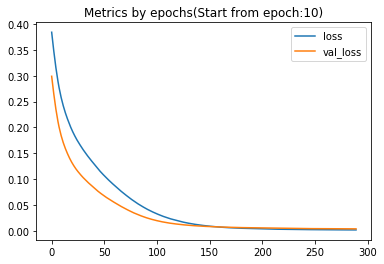

before train: Init time: 1590506690.046
after train, finish time: 1590506901.314
training time {} 211.268
Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_301 (Dense)            (None, 20)                900       
_________________________________________________________________
dense_303 (Dense)            (None, 310)               6510      
_________________________________________________________________
dropout_121 (Dropout)        (None, 310)               0         
_________________________________________________________________
dense_304 (Dense)            (None, 310)               96410     
_________________________________________________________________
dropout_122 (Dropout)        (None, 310)               0         
_________________________________________________________________
dense_305 (Dense)            (None, 280)               87080     
_____________

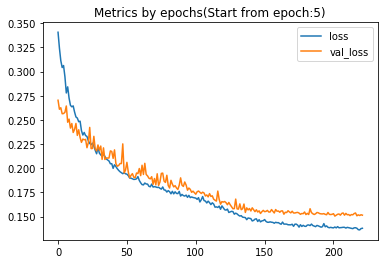

[250, 280, 250]
Columns datasets Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5', 'pcs6', 'pcs7',
       'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13', 'pcs14', 'pcs15',
       'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21', 'pcs22', 'pcs23',
       'pcs24'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 44)
Shape datasets xval: (4264, 44)
Shape datasets xtest: (4735, 44)
Columns datasets after normalize. Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'pcs0', 'pcs1', 'pcs

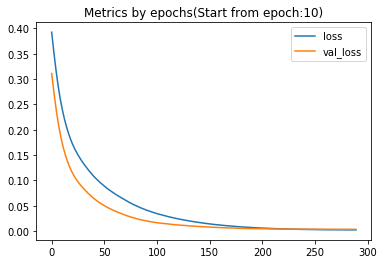

before train: Init time: 1590507072.106
after train, finish time: 1590507270.496
training time {} 198.39
Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_307 (Dense)            (None, 20)                900       
_________________________________________________________________
dense_309 (Dense)            (None, 250)               5250      
_________________________________________________________________
dropout_123 (Dropout)        (None, 250)               0         
_________________________________________________________________
dense_310 (Dense)            (None, 280)               70280     
_________________________________________________________________
dropout_124 (Dropout)        (None, 280)               0         
_________________________________________________________________
dense_311 (Dense)            (None, 250)               70250     
______________

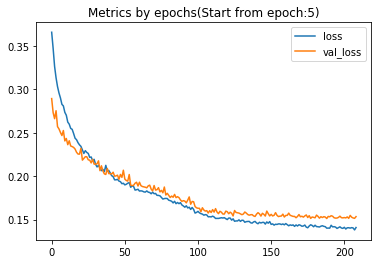

[280, 280, 220]
Columns datasets Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5', 'pcs6', 'pcs7',
       'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13', 'pcs14', 'pcs15',
       'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21', 'pcs22', 'pcs23',
       'pcs24'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 44)
Shape datasets xval: (4264, 44)
Shape datasets xtest: (4735, 44)
Columns datasets after normalize. Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'pcs0', 'pcs1', 'pcs

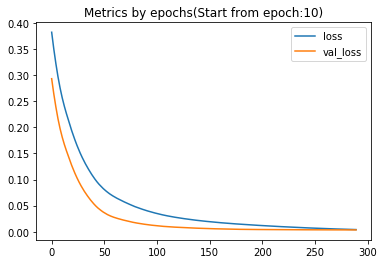

before train: Init time: 1590507442.213
after train, finish time: 1590507624.062
training time {} 181.849
Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_313 (Dense)            (None, 20)                900       
_________________________________________________________________
dense_315 (Dense)            (None, 280)               5880      
_________________________________________________________________
dropout_125 (Dropout)        (None, 280)               0         
_________________________________________________________________
dense_316 (Dense)            (None, 280)               78680     
_________________________________________________________________
dropout_126 (Dropout)        (None, 280)               0         
_________________________________________________________________
dense_317 (Dense)            (None, 220)               61820     
_____________

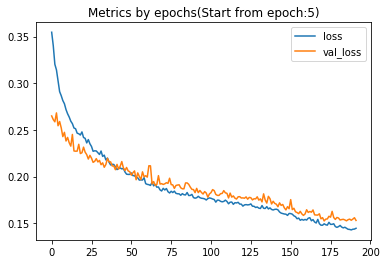

[310, 310, 250]
Columns datasets Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5', 'pcs6', 'pcs7',
       'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13', 'pcs14', 'pcs15',
       'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21', 'pcs22', 'pcs23',
       'pcs24'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 44)
Shape datasets xval: (4264, 44)
Shape datasets xtest: (4735, 44)
Columns datasets after normalize. Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'pcs0', 'pcs1', 'pcs

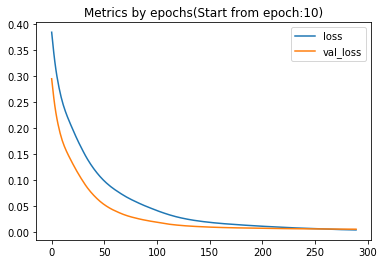

before train: Init time: 1590507795.377
after train, finish time: 1590507990.599
training time {} 195.222
Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_319 (Dense)            (None, 20)                900       
_________________________________________________________________
dense_321 (Dense)            (None, 310)               6510      
_________________________________________________________________
dropout_127 (Dropout)        (None, 310)               0         
_________________________________________________________________
dense_322 (Dense)            (None, 310)               96410     
_________________________________________________________________
dropout_128 (Dropout)        (None, 310)               0         
_________________________________________________________________
dense_323 (Dense)            (None, 250)               77750     
_____________

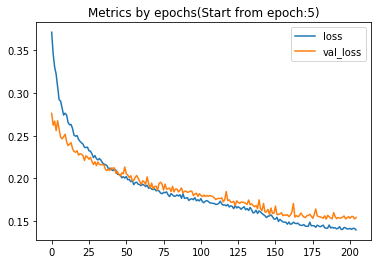

[220, 340, 220]
Columns datasets Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5', 'pcs6', 'pcs7',
       'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13', 'pcs14', 'pcs15',
       'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21', 'pcs22', 'pcs23',
       'pcs24'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 44)
Shape datasets xval: (4264, 44)
Shape datasets xtest: (4735, 44)
Columns datasets after normalize. Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'pcs0', 'pcs1', 'pcs

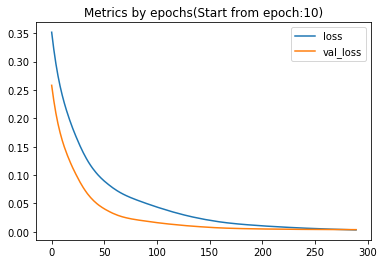

before train: Init time: 1590508162.108
after train, finish time: 1590508348.436
training time {} 186.328
Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_325 (Dense)            (None, 20)                900       
_________________________________________________________________
dense_327 (Dense)            (None, 220)               4620      
_________________________________________________________________
dropout_129 (Dropout)        (None, 220)               0         
_________________________________________________________________
dense_328 (Dense)            (None, 340)               75140     
_________________________________________________________________
dropout_130 (Dropout)        (None, 340)               0         
_________________________________________________________________
dense_329 (Dense)            (None, 220)               75020     
_____________

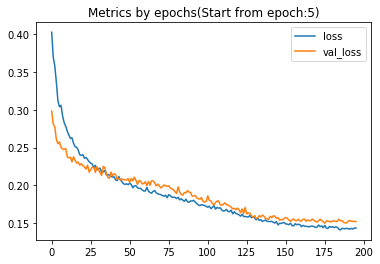

[220, 370, 220]
Columns datasets Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5', 'pcs6', 'pcs7',
       'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13', 'pcs14', 'pcs15',
       'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21', 'pcs22', 'pcs23',
       'pcs24'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 44)
Shape datasets xval: (4264, 44)
Shape datasets xtest: (4735, 44)
Columns datasets after normalize. Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'pcs0', 'pcs1', 'pcs

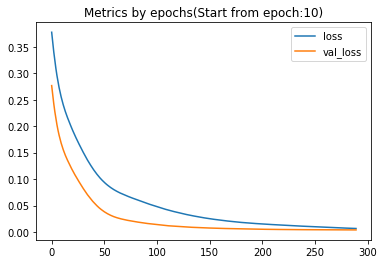

before train: Init time: 1590508519.291
after train, finish time: 1590508700.869
training time {} 181.578
Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_331 (Dense)            (None, 20)                900       
_________________________________________________________________
dense_333 (Dense)            (None, 220)               4620      
_________________________________________________________________
dropout_131 (Dropout)        (None, 220)               0         
_________________________________________________________________
dense_334 (Dense)            (None, 370)               81770     
_________________________________________________________________
dropout_132 (Dropout)        (None, 370)               0         
_________________________________________________________________
dense_335 (Dense)            (None, 220)               81620     
_____________

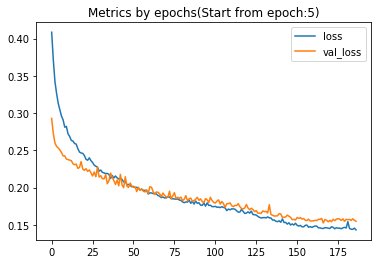

[250, 340, 220]
Columns datasets Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5', 'pcs6', 'pcs7',
       'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13', 'pcs14', 'pcs15',
       'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21', 'pcs22', 'pcs23',
       'pcs24'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 44)
Shape datasets xval: (4264, 44)
Shape datasets xtest: (4735, 44)
Columns datasets after normalize. Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'pcs0', 'pcs1', 'pcs

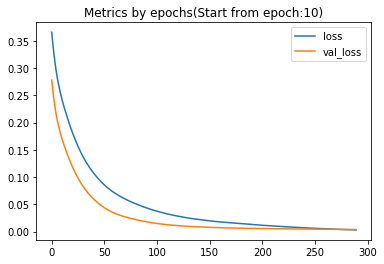

before train: Init time: 1590508874.318
after train, finish time: 1590509080.327
training time {} 206.01
Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_337 (Dense)            (None, 20)                900       
_________________________________________________________________
dense_339 (Dense)            (None, 250)               5250      
_________________________________________________________________
dropout_133 (Dropout)        (None, 250)               0         
_________________________________________________________________
dense_340 (Dense)            (None, 340)               85340     
_________________________________________________________________
dropout_134 (Dropout)        (None, 340)               0         
_________________________________________________________________
dense_341 (Dense)            (None, 220)               75020     
______________

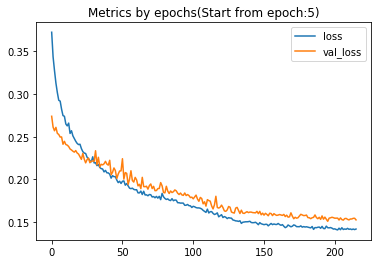

[280, 340, 250]
Columns datasets Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5', 'pcs6', 'pcs7',
       'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13', 'pcs14', 'pcs15',
       'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21', 'pcs22', 'pcs23',
       'pcs24'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 44)
Shape datasets xval: (4264, 44)
Shape datasets xtest: (4735, 44)
Columns datasets after normalize. Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'pcs0', 'pcs1', 'pcs

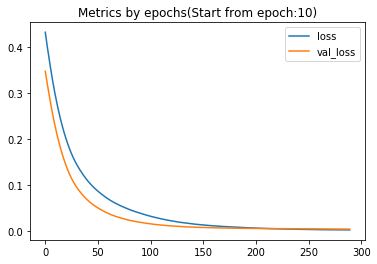

before train: Init time: 1590509252.021
after train, finish time: 1590509424.203
training time {} 172.182
Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_343 (Dense)            (None, 20)                900       
_________________________________________________________________
dense_345 (Dense)            (None, 280)               5880      
_________________________________________________________________
dropout_135 (Dropout)        (None, 280)               0         
_________________________________________________________________
dense_346 (Dense)            (None, 340)               95540     
_________________________________________________________________
dropout_136 (Dropout)        (None, 340)               0         
_________________________________________________________________
dense_347 (Dense)            (None, 250)               85250     
_____________

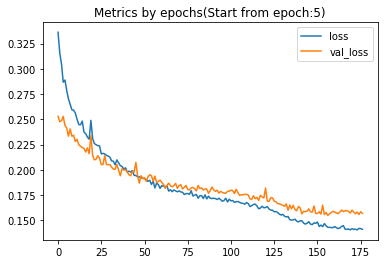

[340, 370, 280]
Columns datasets Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5', 'pcs6', 'pcs7',
       'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13', 'pcs14', 'pcs15',
       'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21', 'pcs22', 'pcs23',
       'pcs24'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 44)
Shape datasets xval: (4264, 44)
Shape datasets xtest: (4735, 44)
Columns datasets after normalize. Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'pcs0', 'pcs1', 'pcs

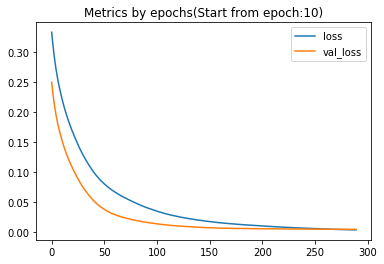

before train: Init time: 1590509597.771
after train, finish time: 1590509820.72
training time {} 222.948
Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_349 (Dense)            (None, 20)                900       
_________________________________________________________________
dense_351 (Dense)            (None, 340)               7140      
_________________________________________________________________
dropout_137 (Dropout)        (None, 340)               0         
_________________________________________________________________
dense_352 (Dense)            (None, 370)               126170    
_________________________________________________________________
dropout_138 (Dropout)        (None, 370)               0         
_________________________________________________________________
dense_353 (Dense)            (None, 280)               103880    
______________

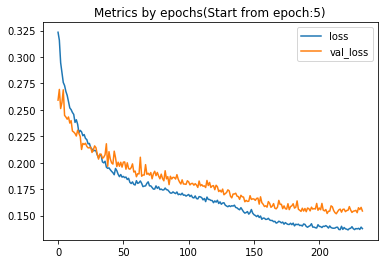

[310, 340, 220]
Columns datasets Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5', 'pcs6', 'pcs7',
       'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13', 'pcs14', 'pcs15',
       'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21', 'pcs22', 'pcs23',
       'pcs24'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 44)
Shape datasets xval: (4264, 44)
Shape datasets xtest: (4735, 44)
Columns datasets after normalize. Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'pcs0', 'pcs1', 'pcs

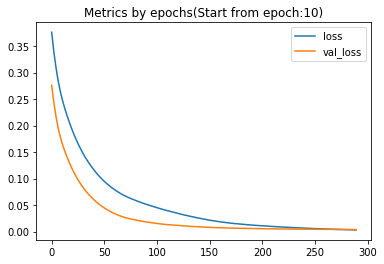

before train: Init time: 1590509989.288
after train, finish time: 1590510190.582
training time {} 201.294
Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_355 (Dense)            (None, 20)                900       
_________________________________________________________________
dense_357 (Dense)            (None, 310)               6510      
_________________________________________________________________
dropout_139 (Dropout)        (None, 310)               0         
_________________________________________________________________
dense_358 (Dense)            (None, 340)               105740    
_________________________________________________________________
dropout_140 (Dropout)        (None, 340)               0         
_________________________________________________________________
dense_359 (Dense)            (None, 220)               75020     
_____________

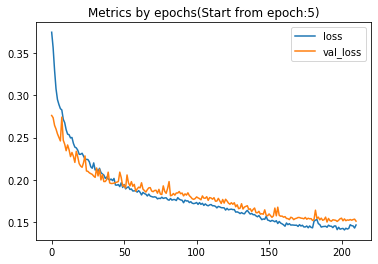

RMSE mean 10 rams: 500.27387994045347
Best RMSE: 475.84894244893394
R2 mean 10 rams: 0.5550362586630855


In [97]:
values_rmse = []
values_r2 = []
best_rmse = 100000.0
import random
for i in range(0,10):
    units2 = []
    units = []
    for i in range(3):
        units2.append(random.randrange(220,400,30))
        units2 = sorted(units2, reverse=True)
    units.append(units2[1])
    units.append(units2[0])
    units.append(units2[2])
    print(units)
    optimizer=Adam(learning_rate=0.00015)
    model, scalery, rmse_train, rmse_val, rmse_test, r2_train, r2_val, r2_test, time_training = train_complete_model2(x_train, x_val, x_test, verbose_train=False, optimizer=optimizer, drop_columns=[],units=units,train_aec=True)
    values_rmse.append(rmse_test)
    values_r2.append(r2_test)
    if (rmse_test < best_rmse):
        best_model = model
        best_rmse = rmse_test
print("RMSE mean 10 rams: {}".format(np.mean(values_rmse)))
print("Best RMSE: {}".format(best_rmse))
print("R2 mean 10 rams: {}".format(np.mean(values_r2)))

<!-- <span style="color:blue">
     -->
### Best Configuration. execute Neural Net model with autoencoder.
<!-- - Optimizer: SGD with learning rate 0.001.
- 3 layers with [85, 80, 60] units.
- first layer: initialization random uniform.
- we execute 10 runs and calculate the mean for result reports.
</span> -->

In [99]:
def executar(train_aec=True, with_aec=True):
    values_rmse = []
    values_r2 = []
    best_rmse = 100000.0
    import random
    stats = pd.DataFrame(
        {
            "rmse_train":[], 
            "rmse_val"  :[], 
            "rmse_test" :[], 
            "r2_train"  :[], 
            "r2_val"    :[],
            "r2_test"   :[],
        }
    ) 
    for i in range(0,10):
        units = [340, 380, 340]
        print(units)
        optimizer=Adam(learning_rate=0.00015)
        model, scalery, rmse_train, rmse_val, rmse_test, r2_train, r2_val, r2_test, time_training = train_complete_model2(x_train, x_val, x_test, verbose_train=False, optimizer=optimizer, drop_columns=[],units=units,train_aec=train_aec, with_aec=with_aec, aec_units=30)
        stats = stats.append({
            "rmse_train":rmse_train, 
            "rmse_val"  :rmse_val, 
            "rmse_test" :rmse_test, 
            "r2_train"  :r2_train, 
            "r2_val"    :r2_val,
            "r2_test"   :r2_test,
        }, 
            ignore_index=True)
        values_rmse.append(rmse_test)
        values_r2.append(r2_test)
        if (rmse_test < best_rmse):
            best_model = model
            best_rmse = rmse_test
    print("RMSE mean 10 rams: {}".format(np.mean(values_rmse)))
    print("Best RMSE: {}".format(best_rmse))
    print("R2 mean 10 rams: {}".format(np.mean(values_r2)))
    return stats

[340, 380, 340]
Columns datasets Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5', 'pcs6', 'pcs7',
       'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13', 'pcs14', 'pcs15',
       'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21', 'pcs22', 'pcs23',
       'pcs24'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 44)
Shape datasets xval: (4264, 44)
Shape datasets xtest: (4735, 44)
Columns datasets after normalize. Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'pcs0', 'pcs1', 'pcs

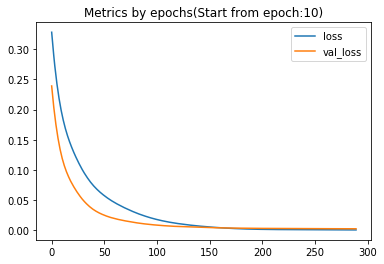

before train: Init time: 1590511271.57
after train, finish time: 1590511507.095
training time {} 235.525
Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_361 (Dense)            (None, 30)                1350      
_________________________________________________________________
dense_363 (Dense)            (None, 340)               10540     
_________________________________________________________________
dropout_141 (Dropout)        (None, 340)               0         
_________________________________________________________________
dense_364 (Dense)            (None, 380)               129580    
_________________________________________________________________
dropout_142 (Dropout)        (None, 380)               0         
_________________________________________________________________
dense_365 (Dense)            (None, 340)               129540    
______________

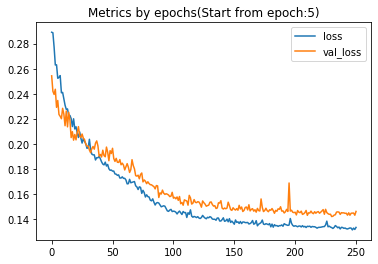

[340, 380, 340]
Columns datasets Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5', 'pcs6', 'pcs7',
       'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13', 'pcs14', 'pcs15',
       'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21', 'pcs22', 'pcs23',
       'pcs24'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 44)
Shape datasets xval: (4264, 44)
Shape datasets xtest: (4735, 44)
Columns datasets after normalize. Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'pcs0', 'pcs1', 'pcs

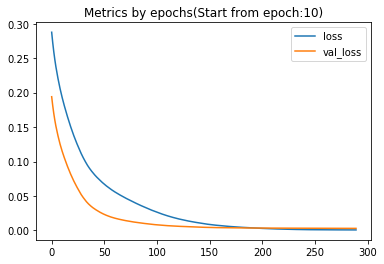

before train: Init time: 1590511675.834
after train, finish time: 1590511837.608
training time {} 161.774
Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_367 (Dense)            (None, 30)                1350      
_________________________________________________________________
dense_369 (Dense)            (None, 340)               10540     
_________________________________________________________________
dropout_143 (Dropout)        (None, 340)               0         
_________________________________________________________________
dense_370 (Dense)            (None, 380)               129580    
_________________________________________________________________
dropout_144 (Dropout)        (None, 380)               0         
_________________________________________________________________
dense_371 (Dense)            (None, 340)               129540    
_____________

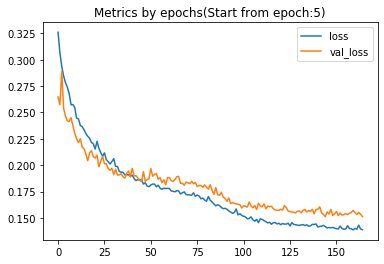

[340, 380, 340]
Columns datasets Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5', 'pcs6', 'pcs7',
       'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13', 'pcs14', 'pcs15',
       'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21', 'pcs22', 'pcs23',
       'pcs24'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 44)
Shape datasets xval: (4264, 44)
Shape datasets xtest: (4735, 44)
Columns datasets after normalize. Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'pcs0', 'pcs1', 'pcs

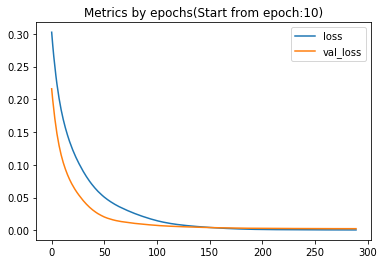

before train: Init time: 1590512009.549
after train, finish time: 1590512251.421
training time {} 241.872
Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_373 (Dense)            (None, 30)                1350      
_________________________________________________________________
dense_375 (Dense)            (None, 340)               10540     
_________________________________________________________________
dropout_145 (Dropout)        (None, 340)               0         
_________________________________________________________________
dense_376 (Dense)            (None, 380)               129580    
_________________________________________________________________
dropout_146 (Dropout)        (None, 380)               0         
_________________________________________________________________
dense_377 (Dense)            (None, 340)               129540    
_____________

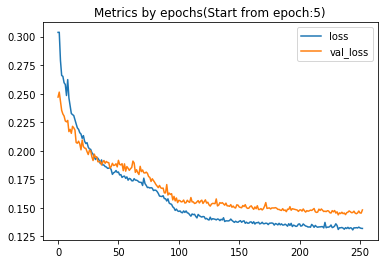

[340, 380, 340]
Columns datasets Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5', 'pcs6', 'pcs7',
       'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13', 'pcs14', 'pcs15',
       'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21', 'pcs22', 'pcs23',
       'pcs24'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 44)
Shape datasets xval: (4264, 44)
Shape datasets xtest: (4735, 44)
Columns datasets after normalize. Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'pcs0', 'pcs1', 'pcs

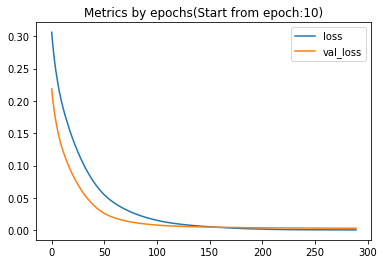

before train: Init time: 1590512424.15
after train, finish time: 1590512589.047
training time {} 164.897
Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_379 (Dense)            (None, 30)                1350      
_________________________________________________________________
dense_381 (Dense)            (None, 340)               10540     
_________________________________________________________________
dropout_147 (Dropout)        (None, 340)               0         
_________________________________________________________________
dense_382 (Dense)            (None, 380)               129580    
_________________________________________________________________
dropout_148 (Dropout)        (None, 380)               0         
_________________________________________________________________
dense_383 (Dense)            (None, 340)               129540    
______________

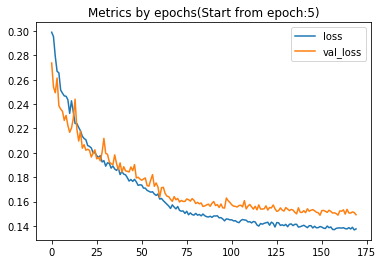

[340, 380, 340]
Columns datasets Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5', 'pcs6', 'pcs7',
       'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13', 'pcs14', 'pcs15',
       'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21', 'pcs22', 'pcs23',
       'pcs24'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 44)
Shape datasets xval: (4264, 44)
Shape datasets xtest: (4735, 44)
Columns datasets after normalize. Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'pcs0', 'pcs1', 'pcs

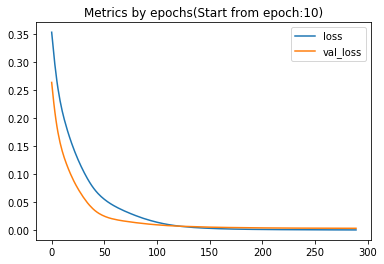

before train: Init time: 1590512759.656
after train, finish time: 1590512996.824
training time {} 237.168
Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_385 (Dense)            (None, 30)                1350      
_________________________________________________________________
dense_387 (Dense)            (None, 340)               10540     
_________________________________________________________________
dropout_149 (Dropout)        (None, 340)               0         
_________________________________________________________________
dense_388 (Dense)            (None, 380)               129580    
_________________________________________________________________
dropout_150 (Dropout)        (None, 380)               0         
_________________________________________________________________
dense_389 (Dense)            (None, 340)               129540    
_____________

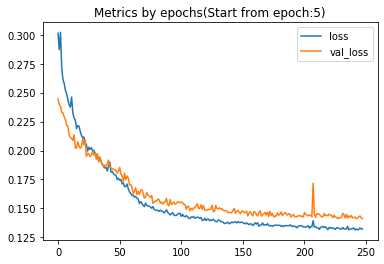

[340, 380, 340]
Columns datasets Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5', 'pcs6', 'pcs7',
       'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13', 'pcs14', 'pcs15',
       'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21', 'pcs22', 'pcs23',
       'pcs24'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 44)
Shape datasets xval: (4264, 44)
Shape datasets xtest: (4735, 44)
Columns datasets after normalize. Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'pcs0', 'pcs1', 'pcs

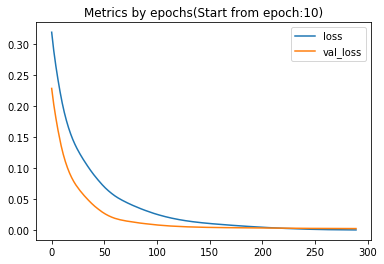

before train: Init time: 1590513168.786
after train, finish time: 1590513314.243
training time {} 145.456
Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_391 (Dense)            (None, 30)                1350      
_________________________________________________________________
dense_393 (Dense)            (None, 340)               10540     
_________________________________________________________________
dropout_151 (Dropout)        (None, 340)               0         
_________________________________________________________________
dense_394 (Dense)            (None, 380)               129580    
_________________________________________________________________
dropout_152 (Dropout)        (None, 380)               0         
_________________________________________________________________
dense_395 (Dense)            (None, 340)               129540    
_____________

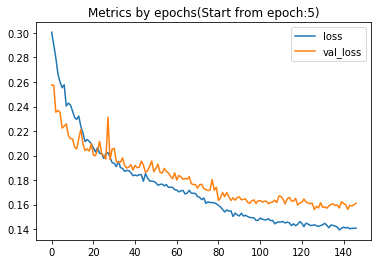

[340, 380, 340]
Columns datasets Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5', 'pcs6', 'pcs7',
       'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13', 'pcs14', 'pcs15',
       'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21', 'pcs22', 'pcs23',
       'pcs24'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 44)
Shape datasets xval: (4264, 44)
Shape datasets xtest: (4735, 44)
Columns datasets after normalize. Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'pcs0', 'pcs1', 'pcs

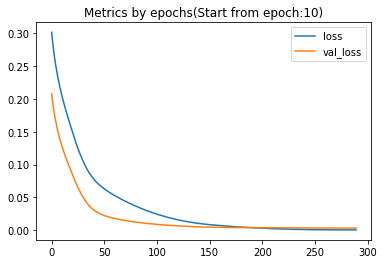

before train: Init time: 1590513486.505
after train, finish time: 1590513618.49
training time {} 131.985
Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_397 (Dense)            (None, 30)                1350      
_________________________________________________________________
dense_399 (Dense)            (None, 340)               10540     
_________________________________________________________________
dropout_153 (Dropout)        (None, 340)               0         
_________________________________________________________________
dense_400 (Dense)            (None, 380)               129580    
_________________________________________________________________
dropout_154 (Dropout)        (None, 380)               0         
_________________________________________________________________
dense_401 (Dense)            (None, 340)               129540    
______________

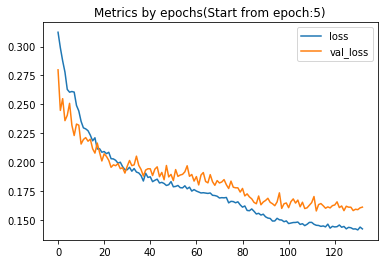

[340, 380, 340]
Columns datasets Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5', 'pcs6', 'pcs7',
       'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13', 'pcs14', 'pcs15',
       'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21', 'pcs22', 'pcs23',
       'pcs24'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 44)
Shape datasets xval: (4264, 44)
Shape datasets xtest: (4735, 44)
Columns datasets after normalize. Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'pcs0', 'pcs1', 'pcs

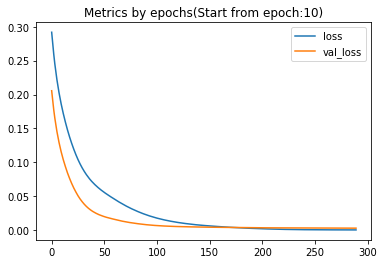

before train: Init time: 1590513789.977
after train, finish time: 1590513918.363
training time {} 128.385
Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_403 (Dense)            (None, 30)                1350      
_________________________________________________________________
dense_405 (Dense)            (None, 340)               10540     
_________________________________________________________________
dropout_155 (Dropout)        (None, 340)               0         
_________________________________________________________________
dense_406 (Dense)            (None, 380)               129580    
_________________________________________________________________
dropout_156 (Dropout)        (None, 380)               0         
_________________________________________________________________
dense_407 (Dense)            (None, 340)               129540    
_____________

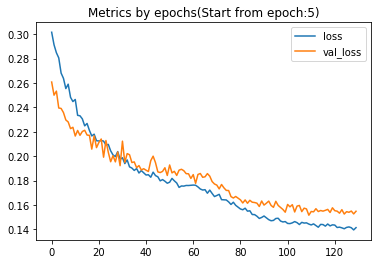

[340, 380, 340]
Columns datasets Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5', 'pcs6', 'pcs7',
       'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13', 'pcs14', 'pcs15',
       'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21', 'pcs22', 'pcs23',
       'pcs24'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 44)
Shape datasets xval: (4264, 44)
Shape datasets xtest: (4735, 44)
Columns datasets after normalize. Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'pcs0', 'pcs1', 'pcs

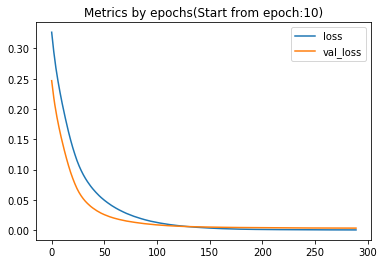

before train: Init time: 1590514089.265
after train, finish time: 1590514311.781
training time {} 222.516
Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_409 (Dense)            (None, 30)                1350      
_________________________________________________________________
dense_411 (Dense)            (None, 340)               10540     
_________________________________________________________________
dropout_157 (Dropout)        (None, 340)               0         
_________________________________________________________________
dense_412 (Dense)            (None, 380)               129580    
_________________________________________________________________
dropout_158 (Dropout)        (None, 380)               0         
_________________________________________________________________
dense_413 (Dense)            (None, 340)               129540    
_____________

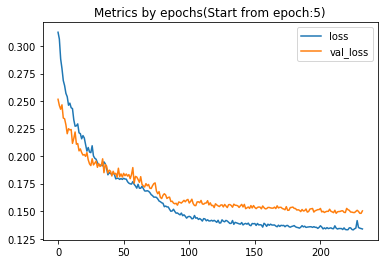

[340, 380, 340]
Columns datasets Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5', 'pcs6', 'pcs7',
       'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13', 'pcs14', 'pcs15',
       'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21', 'pcs22', 'pcs23',
       'pcs24'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 44)
Shape datasets xval: (4264, 44)
Shape datasets xtest: (4735, 44)
Columns datasets after normalize. Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'pcs0', 'pcs1', 'pcs

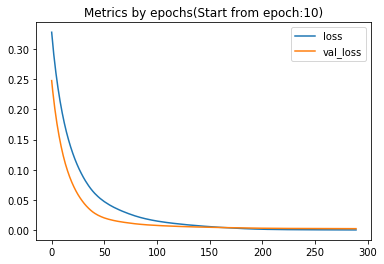

before train: Init time: 1590514483.639
after train, finish time: 1590514719.756
training time {} 236.117
Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_415 (Dense)            (None, 30)                1350      
_________________________________________________________________
dense_417 (Dense)            (None, 340)               10540     
_________________________________________________________________
dropout_159 (Dropout)        (None, 340)               0         
_________________________________________________________________
dense_418 (Dense)            (None, 380)               129580    
_________________________________________________________________
dropout_160 (Dropout)        (None, 380)               0         
_________________________________________________________________
dense_419 (Dense)            (None, 340)               129540    
_____________

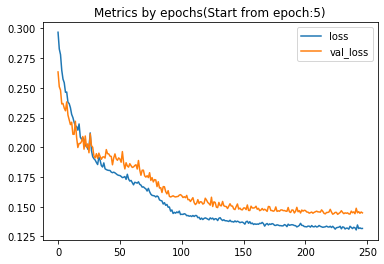

RMSE mean 10 rams: 500.8648608859406
Best RMSE: 465.81179864102216
R2 mean 10 rams: 0.5527840645750606


In [100]:
#Execute model with autoencoder training.
stats = executar(train_aec=True)

In [101]:
print("AEC + ANN")  
stats

AEC + ANN


,rmse_train,rmse_val,rmse_test,r2_train,r2_val,r2_test
0,650.549767,595.094684,511.660542,0.461989,0.467977,0.535067
1,651.168130,584.481429,491.555887,0.460966,0.486784,0.570886
2,619.741347,564.271511,470.093339,0.511740,0.521662,0.607540
3,634.776581,569.534322,475.667623,0.487762,0.512698,0.598178
4,596.015895,544.046505,465.811799,0.548409,0.555337,0.614657
5,707.565357,636.993405,554.699883,0.363552,0.390423,0.453559
6,704.872685,631.880400,547.207312,0.368387,0.400170,0.468222
7,687.997468,613.132379,526.234345,0.398267,0.435236,0.508204
8,615.773837,562.403516,473.039566,0.517972,0.524824,0.602605
9,633.444731,575.561076,492.678314,0.489909,0.502330,0.568924


In [102]:
printSTDVARMEAN(stats, "AEC + ANN")

AEC + ANN
STD
rmse_train    38.408654
rmse_val      31.029300
rmse_test     32.565179
r2_train       0.064137
r2_val         0.055356
r2_test        0.058930
dtype: float64
VAR
rmse_train    1475.224712
rmse_val       962.817470
rmse_test     1060.490880
r2_train         0.004114
r2_val           0.003064
r2_test          0.003473
dtype: float64
MEAN
rmse_train    650.190580
rmse_val      587.739923
rmse_test     500.864861
r2_train        0.460895
r2_val          0.479744
r2_test         0.552784
dtype: float64


### Best Configuration. execute Neural Net model without autoencoder.

[340, 380, 340]
Columns datasets Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5', 'pcs6', 'pcs7',
       'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13', 'pcs14', 'pcs15',
       'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21', 'pcs22', 'pcs23',
       'pcs24'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 44)
Shape datasets xval: (4264, 44)
Shape datasets xtest: (4735, 44)
Columns datasets after normalize. Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'pcs0', 'pcs1', 'pcs

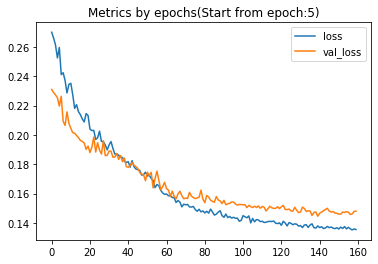

[340, 380, 340]
Columns datasets Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5', 'pcs6', 'pcs7',
       'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13', 'pcs14', 'pcs15',
       'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21', 'pcs22', 'pcs23',
       'pcs24'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 44)
Shape datasets xval: (4264, 44)
Shape datasets xtest: (4735, 44)
Columns datasets after normalize. Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'pcs0', 'pcs1', 'pcs

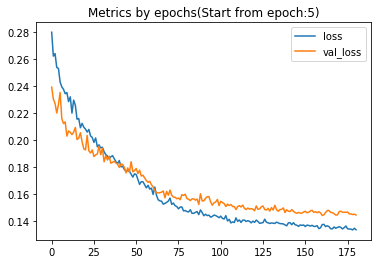

[340, 380, 340]
Columns datasets Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5', 'pcs6', 'pcs7',
       'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13', 'pcs14', 'pcs15',
       'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21', 'pcs22', 'pcs23',
       'pcs24'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 44)
Shape datasets xval: (4264, 44)
Shape datasets xtest: (4735, 44)
Columns datasets after normalize. Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'pcs0', 'pcs1', 'pcs

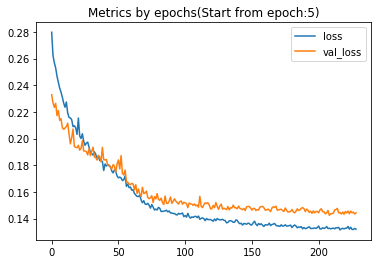

[340, 380, 340]
Columns datasets Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5', 'pcs6', 'pcs7',
       'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13', 'pcs14', 'pcs15',
       'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21', 'pcs22', 'pcs23',
       'pcs24'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 44)
Shape datasets xval: (4264, 44)
Shape datasets xtest: (4735, 44)
Columns datasets after normalize. Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'pcs0', 'pcs1', 'pcs

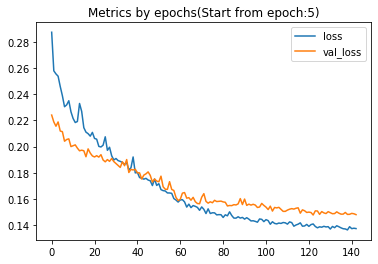

[340, 380, 340]
Columns datasets Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5', 'pcs6', 'pcs7',
       'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13', 'pcs14', 'pcs15',
       'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21', 'pcs22', 'pcs23',
       'pcs24'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 44)
Shape datasets xval: (4264, 44)
Shape datasets xtest: (4735, 44)
Columns datasets after normalize. Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'pcs0', 'pcs1', 'pcs

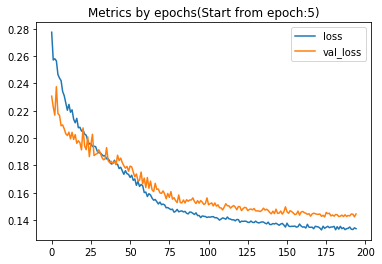

[340, 380, 340]
Columns datasets Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5', 'pcs6', 'pcs7',
       'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13', 'pcs14', 'pcs15',
       'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21', 'pcs22', 'pcs23',
       'pcs24'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 44)
Shape datasets xval: (4264, 44)
Shape datasets xtest: (4735, 44)
Columns datasets after normalize. Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'pcs0', 'pcs1', 'pcs

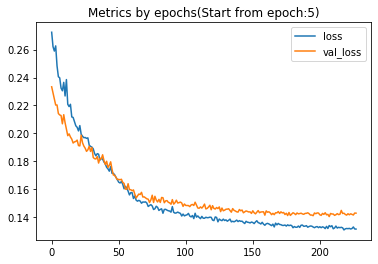

[340, 380, 340]
Columns datasets Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5', 'pcs6', 'pcs7',
       'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13', 'pcs14', 'pcs15',
       'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21', 'pcs22', 'pcs23',
       'pcs24'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 44)
Shape datasets xval: (4264, 44)
Shape datasets xtest: (4735, 44)
Columns datasets after normalize. Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'pcs0', 'pcs1', 'pcs

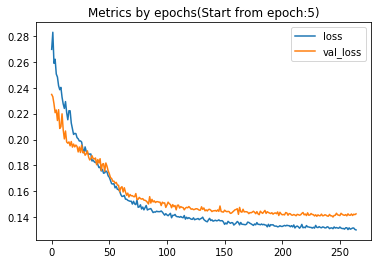

[340, 380, 340]
Columns datasets Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5', 'pcs6', 'pcs7',
       'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13', 'pcs14', 'pcs15',
       'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21', 'pcs22', 'pcs23',
       'pcs24'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 44)
Shape datasets xval: (4264, 44)
Shape datasets xtest: (4735, 44)
Columns datasets after normalize. Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'pcs0', 'pcs1', 'pcs

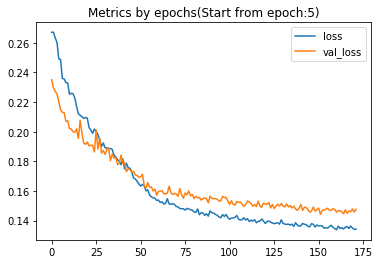

[340, 380, 340]
Columns datasets Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5', 'pcs6', 'pcs7',
       'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13', 'pcs14', 'pcs15',
       'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21', 'pcs22', 'pcs23',
       'pcs24'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 44)
Shape datasets xval: (4264, 44)
Shape datasets xtest: (4735, 44)
Columns datasets after normalize. Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'pcs0', 'pcs1', 'pcs

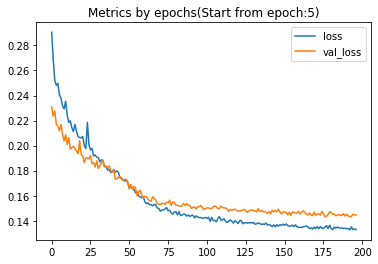

[340, 380, 340]
Columns datasets Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5', 'pcs6', 'pcs7',
       'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13', 'pcs14', 'pcs15',
       'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21', 'pcs22', 'pcs23',
       'pcs24'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 44)
Shape datasets xval: (4264, 44)
Shape datasets xtest: (4735, 44)
Columns datasets after normalize. Index(['triple', 'bgp', 'leftjoin', 'union', 'filter', 'graph', 'extend',
       'minus', 'order', 'project', 'distinct', 'reduced', 'group', 'slice',
       'treesize', 'joins_count', 'filter_uri', 'filter_num', 'filter_literal',
       'pcs0', 'pcs1', 'pcs

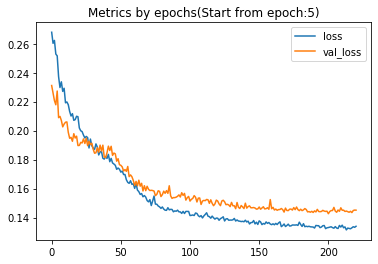

RMSE mean 10 rams: 465.67061607636924
Best RMSE: 450.25340295986854
R2 mean 10 rams: 0.6146934104007691


In [103]:
stastNoAEC2 = executar(with_aec=False, train_aec=False)

In [104]:
printSTDVARMEAN(stastNoAEC2, "ANN Without AEC")

ANN Without AEC
STD
rmse_train    17.311804
rmse_val       9.725300
rmse_test     11.094441
r2_train       0.027221
r2_val         0.016336
r2_test        0.018351
dtype: float64
VAR
rmse_train    299.698567
rmse_val       94.581465
rmse_test     123.086623
r2_train        0.000741
r2_val          0.000267
r2_test         0.000337
dtype: float64
MEAN
rmse_train    617.166737
rmse_val      557.696939
rmse_test     465.670616
r2_train        0.515446
r2_val          0.532616
r2_test         0.614693
dtype: float64


### END